##### Import statements

In [3]:
import os
os.environ[ "TF_CPP_MIN_LOG_LEVEL"] = "3"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from utils import train_test_split, feature_label_split, plot_loss
from sklearn.metrics import mean_squared_error

tf.compat.v1.logging.set_verbosity( tf.compat.v1.logging.ERROR)

##### Load dataset

In [4]:
df = pd.read_csv( "../data/airline-passengers.csv", parse_dates=[ "Month"], engine="python", index_col="Month")

df.head( 5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


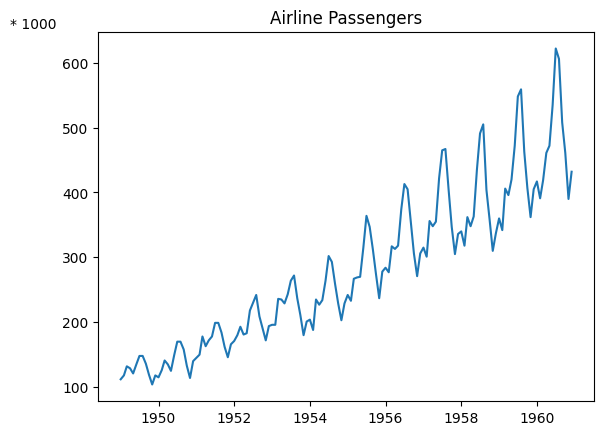

In [5]:
plt.figure()
plt.plot( df)
plt.title( "Airline Passengers")
plt.ylabel( "* 1000", loc="top", rotation=0)
plt.show()

##### Const

In [6]:
LEN = len( df)
LAG = 3

##### Prepare data

In [7]:
data = df[ "Passengers"].values.reshape( -1, 1).astype( "float32")

##### Scale data into [0, 1]

In [8]:
scaler = MinMaxScaler( feature_range=( 0, 1))
data = scaler.fit_transform( data)

##### Train-test split

In [9]:
train, test = train_test_split( data, 0.67)

print( f"shape of train set: { len( train)}")
print( f"shape of test set: { len( test)}")

shape of train set: 96
shape of test set: 48


##### Feature-label split

In [10]:
train_X, train_y = feature_label_split( train, LAG)
test_X, test_y = feature_label_split( test, LAG)

print( f"train_X shape: { train_X.shape}, train_y shape: { train_y.shape}")
print( f"test_X shape: { test_X.shape}, test_y shape: { test_y.shape}")

train_X shape: (92, 3), train_y shape: (92,)
test_X shape: (44, 3), test_y shape: (44,)


##### Reshape input features into (samples, time-steps, features)

In [11]:
train_X = np.reshape( train_X, ( train_X.shape[ 0], LAG, 1))
test_X = np.reshape( test_X, ( test_X.shape[ 0], LAG, 1))

print( f"train_X shape: { train_X.shape}, train_y shape: { train_y.shape}")
print( f"test_X shape: { test_X.shape}, test_y shape: { test_y.shape}")

train_X shape: (92, 3, 1), train_y shape: (92,)
test_X shape: (44, 3, 1), test_y shape: (44,)


##### Create first model

- Regression
- Single LSTM layer with 4 units
- lag = 3, horizon = 1

In [12]:
model = Sequential( [
	LSTM( 4, input_shape=( LAG, 1)),
	Dense( 1)
])

model.compile(
	loss="mean_squared_error",
	optimizer="adam"
)

history = model.fit(
	train_X,
	train_y,
	epochs=20,
	batch_size=1,
	verbose=0
)

##### Plotting loss history

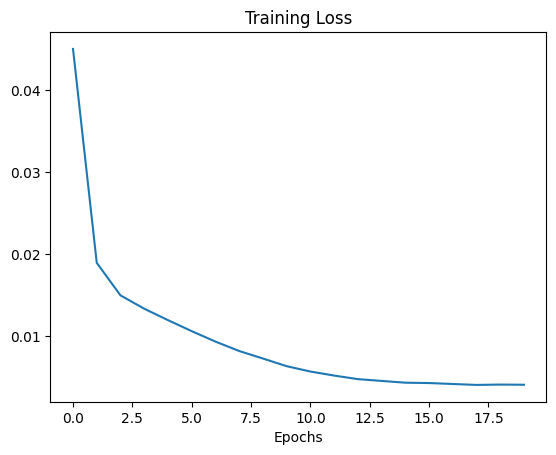

In [13]:
plot_loss( history)

##### Function for Evaluating result

In [14]:
def evaluate( model, lag, data, scaler, train_X, train_y, test_X, test_y):
	train_pred = model.predict( train_X, verbose=0)
	test_pred = model.predict( test_X, verbose=0)

	train_pred = scaler.inverse_transform( train_pred)
	train_true = scaler.inverse_transform( [ train_y])

	test_pred = scaler.inverse_transform( test_pred)
	test_true = scaler.inverse_transform( [ test_y])

	train_score = np.sqrt( mean_squared_error( train_true[ 0], train_pred[ :, 0]))
	print( f"Train Score: { train_score:.2f} RMSE")
	
	test_score = np.sqrt( mean_squared_error( test_true[ 0], test_pred[ :, 0]))
	print( f"Test Score: { test_score:.2f} RMSE")

	train_predict_plot = np.empty_like( data)
	train_predict_plot[ :, :] = np.nan
	train_predict_plot[ lag:len( train_pred) + lag, :] = train_pred

	test_predict_plot = np.empty_like( data)
	test_predict_plot[ :, :] = np.nan
	test_predict_plot[ len( train_pred) + lag * 2 + 1:len( data) - 1, :] = test_pred

	plt.figure()
	plt.plot( scaler.inverse_transform( data), label="Original Data")
	plt.plot( train_predict_plot, label="Train Set Prediction")
	plt.plot( test_predict_plot, label="Test Set Prediction")
	plt.title( "Airline Passengers")
	plt.ylabel( "* 1000", loc="top", rotation=0)
	plt.legend()
	plt.show()

Train Score: 32.56 RMSE
Test Score: 71.16 RMSE


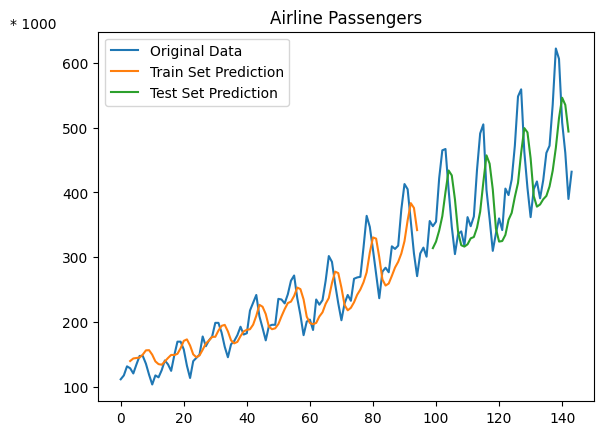

In [15]:
evaluate( model, LAG, data, scaler, train_X, train_y, test_X, test_y)